# Basic flow with a circular cylinder
In this notebook we will simulate the flow past a stationary body.

In [1]:
using ViscousFlow

In [2]:
using Plots
using Statistics

In [3]:
my_params = Dict()

Dict{Any, Any}()

### Problem specification
Set the Reynolds number and free stream. We will set the free stream to be in the $x$ direction, with speed equal to 1.

In [4]:
my_params["Re"] = 200
my_params["freestream speed"] = 1.0
my_params["freestream angle"] = 0.0

0.0

### Discretize
We set the grid Re to 4.0 here to get a quicker solution, though it is generally
better to make this smaller (it defaults to 2.0).

In [10]:
xlim = (-1.5,8.0)
ylim = (-2.0,2.0)
my_params["grid Re"] = 4.0
g = setup_grid(xlim,ylim,my_params,nthreads_max=6)

PhysicalGrid{2}((483, 210), (79, 105), 0.02, ((-1.56, 8.06), (-2.08, 2.08)), 6)

### Set up body and the (null) motion
Here, we will set up a circle of radius 0.5. We also need to supply the spacing between points. For this, we use
the function `surface_point_spacing`

In [11]:
Δs = surface_point_spacing(g,my_params)
body = Circle(0.5,Δs)

Circular body with 112 points and radius 0.5
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


We place the body at a desired location and orientation by creating a *joint*.
This joint "joins" the body to the inertial coordinate system. In order
to create this joint and apply it, we first need to place the joint in the inertial
coordinate system with a `MotionTransform`.

In [12]:
cent = [0.0,0.0] # center of joint with respect to inertial system
α = 0π/180 # angle of joint with respect to inertial system
X = MotionTransform(cent,α)
joint = Joint(X)

Joint of dimension 2 and type FreeJoint2d
   Constrained dofs = [1, 2, 3]
   Exogenous dofs = Int64[]
   Unconstrained dofs = Int64[]


The next two steps will seem unnecessarily cumbersome, but they reveal
an important aspect of how this package treats surface motion. Every
problem with bodies has joints, and every joint has at least one degree
of freedom, even if none of these degrees of freedom is meant to vary in time.

For this reason, we must always create a `RigidBodyMotion` object and a
*joint state vector*, `x`, even if there is no motion. In this example,
`x` is just a vector of 3 zeros (describing the angle, x, and y
coordinates of the joint).

To set the body in place, we use `update_body!(body,x,m)`. After the operation is
applied, `body` is transformed to the correct location/orientation.

In [13]:
m = RigidBodyMotion(joint,body)
x = init_motion_state(body,m)
update_body!(body,x,m)

Circular body with 112 points and radius 0.5
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


Let's plot it just to make sure

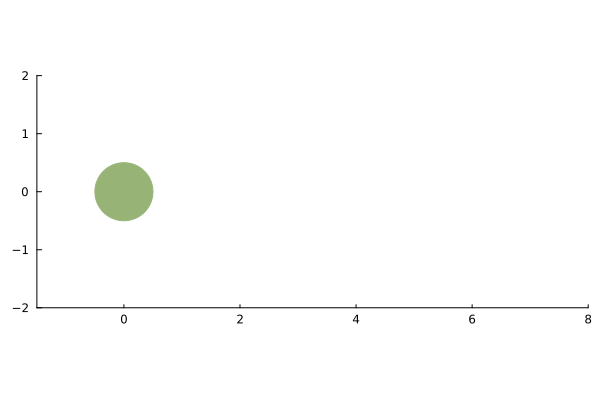

In [14]:
plot(body,xlim=xlim,ylim=ylim)

### Construct a force perturbation in order to break the symmetry

In [15]:
# We create a y force perturbation
σx, σy = 0.5, 0.1 # Spatial extent
x0, y0 = 1.5, 0.0 # Location
amp = 5 # Amplitude
fx, fy = EmptySpatialField(), SpatialGaussian(σx,σy,x0,y0,amp)
force_dist = [fx,fy];

# This function applies the force over a short time interval (Gaussian in time)
function forcing_model!(σ,T,t,fr::AreaRegionCache,phys_params)
    σt = 0.1 # Duration of application
    t0 = 1.5 # Time of application
    modfcn = Gaussian(σt,sqrt(π*σt^2)) >> t0
    σ .= modfcn(t)*fr.generated_field()
end

afm = AreaForcingModel(forcing_model!,spatialfield=force_dist)
forcing_dict = Dict("forcing models" => afm);

### Construct the system structure

In [16]:
sys = viscousflow_system(g,body,phys_params=my_params,motions=m,forcing=forcing_dict);

### Initialize
Now, we initialize with zero vorticity. Note that we do this by calling
`init_sol` with no argument except for `sys` itself.

In [17]:
u0 = init_sol(sys)

(Dual nodes in a (nx = 483, ny = 210) cell grid of type Float64 data
  Number of Dual nodes: (nx = 483, ny = 210), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

and now create the integrator, with a long enough time span to hold the whole
solution history:

In [18]:
tspan = (0.0,60.0)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Dual nodes in a (nx = 483, ny = 210) cell grid of type Float64 data
  Number of Dual nodes: (nx = 483, ny = 210), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

### Solve
Now we are ready to solve the problem. Let's advance the solution to $t = 1$.

In [19]:
step!(integrator,1.0)

  7.705048 seconds (5.40 M allocations: 2.688 GiB, 1.44% gc time, 24.27% compilation time)


...advance further

In [21]:
step!(integrator,30.0)

### Examine
Let's look at the flow field at the end of this interval

In [22]:
sol = integrator.sol;

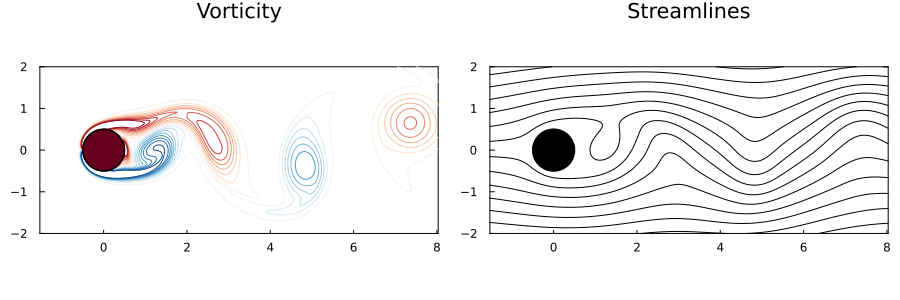

In [23]:
t = 30.0
plot(
plot(vorticity(sol,sys,t),sys,title="Vorticity",clim=(-4,4),levels=range(-4,4,length=20), color = :RdBu,ylim=ylim,bodyfill=true),
plot(streamfunction(sol,sys,t),sys,title="Streamlines",ylim=ylim,color = :Black,bodyfill=true),
    size=(900,300)
    )

#### Pressure field

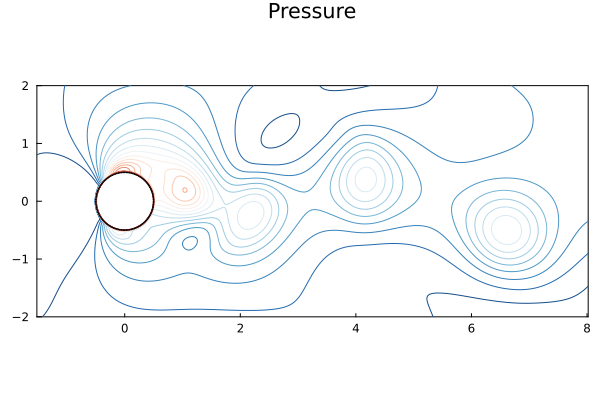

In [24]:
plot(pressure(integrator),sys,title="Pressure",clim=(-1,0.1),levels=range(-1,0.1,length=20), color = :RdBu,ylim=ylim)

#### Surface traction

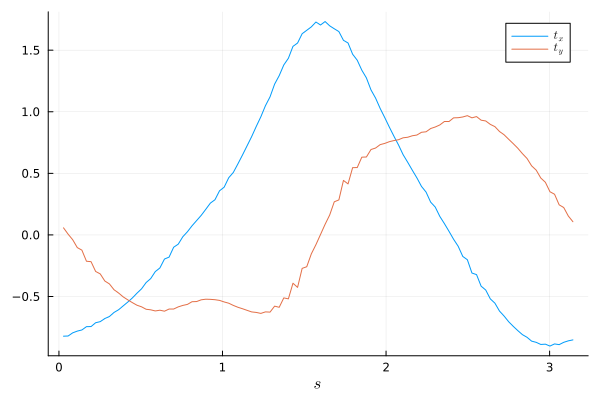

In [25]:
tract = traction(integrator);
plot(arccoord(body),tract.u,label="\$t_x\$",xlabel="\$s\$")
plot!(arccoord(body),tract.v,label="\$t_y\$")

#### Movie of vorticity

[ Info: Saved animation to /Users/jeff/JuliaProjects/ViscousFlow/examples/tmp.gif


Plots.AnimatedGif("/Users/jeff/JuliaProjects/ViscousFlow/examples/tmp.gif")
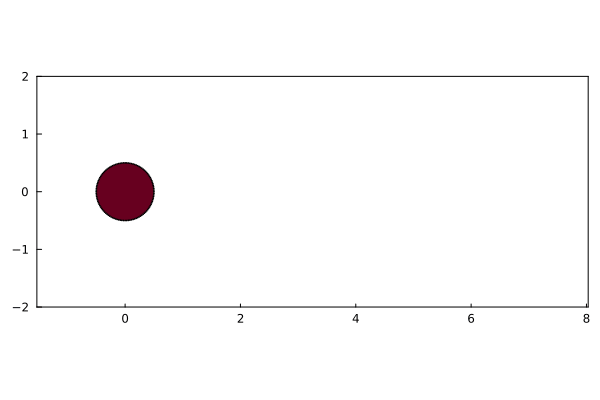

In [26]:
sol = integrator.sol;
@gif for t in 0:0.4:30
   plot(vorticity(sol,sys,t),sys,clim=(-5,5),levels=range(-5,5,length=20), color = :RdBu,ylim=ylim,bodyfill=true)
end

#### Compute the moment and force histories
To do this, we supply the solution history `sol`, the system `sys`, and the index
of the body (1).

In [27]:
sol = integrator.sol;
mom, fx, fy = force(sol,sys,1);

Plot the histories. Note that we are actually plotting the drag and lift
coefficient histories here:
$$ C_D = \dfrac{F_x}{\frac{1}{2}\rho U_\infty^2 L}, \quad C_L = \dfrac{F_y}{\frac{1}{2}\rho U_\infty^2 L}, \quad C_m = \dfrac{M}{\frac{1}{2}\rho U_\infty^2 L^2} $$
Since the quantities in this simulation are already scaled by $\rho$, $U_\infty$, and $L$
(because $\rho$ has been scaled out of the equations, and the free stream speed is
set to 1 and the height of the shape to 1), then we obtain these coefficients by
simply dividing by 1/2, or equivalently, by multiplying by 2:

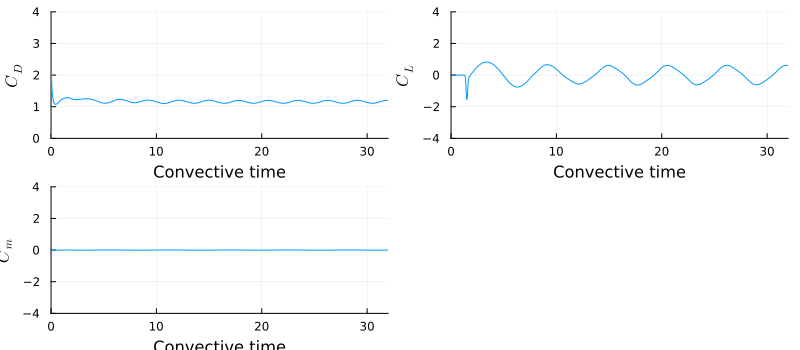

In [28]:
plot(
plot(sol.t,2*fx,xlim=(0,Inf),ylim=(0,4),xlabel="Convective time",ylabel="\$C_D\$",legend=:false),
plot(sol.t,2*fy,xlim=(0,Inf),ylim=(-4,4),xlabel="Convective time",ylabel="\$C_L\$",legend=:false),
plot(sol.t,2*mom,xlim=(0,Inf),ylim=(-4,4),xlabel="Convective time",ylabel="\$C_m\$",legend=:false),
    size=(800,350)
)

The mean drag and lift coefficients (omitting the first two steps) are

In [29]:
meanCD = mean(2*fx[3:end])

1.1684311954818996

In [30]:
meanCL = mean(2*fy[3:end])

0.020937382148467357

In [31]:
meanCm = mean(2*mom[3:end])

-7.377090514005855e-5

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*